[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/NktBkzn/HSE_DL_2021/blob/master/12_week/Weather_forecast_RNN.ipynb)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My Drive/HSE_DL_2021/12_week

Mounted at /content/gdrive
/content/gdrive/My Drive/HSE_DL_2021/12_week


## Задача прогнозирования температуры

Во всех наших примерах в этом разделе мы будем играть с погодой
набором  временных рядов, записанных на метеостанции в Институте биогеохимии им. Макса Планка в Йене, Германия: http://www.bgc-jena.mpg.de/wetter/.

В этом наборе данных записано четырнадцать различных величин (таких как температура воздуха, атмосферное давление, влажность, направление ветра и т. Д.)
каждые десять минут, в течение нескольких лет. Исходные данные относятся к 2003 году, но мы ограничиваемся данными за 2009-2016 годы. Этот набор данных
идеально подходит для обучения работе с числовыми временными рядами. Мы будем использовать его для построения модели, которая принимает в качестве входных данных некоторые данные из недавнего прошлого (
несколько дней стоит данных) и прогнозирует температуру воздуха на 24 часа в будущем.


Посмотрим на данные!

In [6]:
import os


fname = 'data/jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [7]:
import pandas as pd

tmp = pd.read_csv(fname)
tmp.head(1)

Date Time  p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
0  01.01.2009 00:10:00    996.52     -8.02     265.4         -8.9    93.3   

   VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
0          3.33          3.11          0.22       1.94             3.12   

   rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
0       1307.75      1.03           1.75     152.3

переведем все в numpy array

In [8]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [9]:
float_data.shape

(420551, 14)

нарисуем график температуры

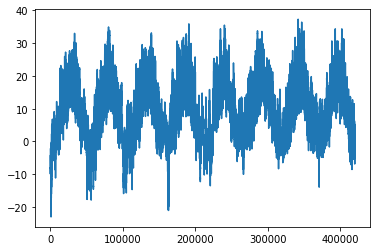

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  # температура
plt.plot(range(len(temp)), temp)
plt.show()

На этом графике вы можете четко увидеть годовую периодичность температуры.

Вот более узкий график данных о температуре за первые десять дней (поскольку данные записываются каждые десять минут, мы получаем 144 точки данных
в день):

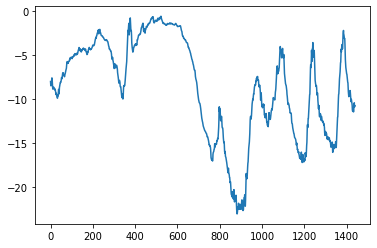

In [11]:
plt.plot(range(1440), temp[:1440])
plt.show()

На этом графике вы можете увидеть ежедневную периодичность, особенно заметную за последние 4 дня. Мы также можем отметить, что этот десятидневный период должен быть
взят из довольно холодного зимнего месяца.

Если бы мы пытались предсказать среднюю температуру для следующего месяца, учитывая данные за несколько месяцев, проблема была бы легкой из-за
достоверной годовой периодичности данных. Но, глядя на данные в масштабе дней, температура выглядит намного более хаотичной. 


In [12]:
TRAIN_VAL_TH = 200000
VAL_TEST_TH = 300000

In [13]:
mean = float_data[:TRAIN_VAL_TH].mean(axis=0)
float_data -= mean
std = float_data[:TRAIN_VAL_TH].std(axis=0)
float_data /= std

In [14]:
float_data.shape

(420551, 14)

Рассмотрим генератор данных, который мы будем использовать. Он возвращает кортеж `(samples, target)`, где `samples` - один батч данных, а
`target` -  массив целевых температур. Требуются следующие аргументы:

* `data`: исходный массив данных с плавающей запятой, который мы только что нормализовали в приведенном выше фрагменте кода.
* `lookback`: Сколько временных шагов назад должны пройти наши входные данные. Выбираем значение, равное 1440 (в нашем случае это кол-во прошедших минут).
* `delay`: через сколько шагов прогнозим
* `min_index` и` max_index`: индексы в массиве `data`, которые разграничивают временные шаги для отрисовки. 
* `shuffle`: перетасовать наши батчи или нарисовать их в хронологическом порядке.
* `batch_size`: количество данных на батч.
* `step`: период во временных шагах, с каким мы производим выборку данных. Мы установим его на 6, чтобы рисовать одну точку данных каждый час. Тогда длина полследовательности будет 1440:6= 240 (т.е. 240 10-ти минутных интервалов)

In [15]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),       # batch size
                           lookback // step, # seq_len
                           data.shape[-1]))  # features number
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):  # loop of batch size len
            indices = range(row - lookback, row, step) # indices form a sequence (total number of sequences = batch size)
            # print('indices', len(list(indices)), list(indices))
            # print(row + delay - step, '\n')
            samples[j] = data[indices]
            # [1] below means that temperature is being a target
            targets[j] = data[row + delay - step][1]
        yield samples, targets


Теперь давайте использовать нашу функцию абстрактного генератора для создания трех генераторов, одного для обучения, одного для проверки и одного для тестирования.


In [16]:
float_data.shape

(420551, 14)

In [17]:
lookback = 1440 
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=TRAIN_VAL_TH,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=TRAIN_VAL_TH+1,
                    max_index=VAL_TEST_TH,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=VAL_TEST_TH+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# number of steps needed to cover the whole datasets
train_steps = (TRAIN_VAL_TH - 0 - lookback) // batch_size
val_steps = (VAL_TEST_TH - (TRAIN_VAL_TH+1) - lookback) // batch_size
test_steps = (len(float_data) - (VAL_TEST_TH+1) - lookback) // batch_size

print(val_steps, test_steps)

769 930


In [18]:
samples, targets = next(val_gen)

samples.shape, targets.shape

((128, 240, 14), (128,))

Немного разберемся с процедурой формирования батча\
Создадим generator с небольшими значениями параметров, чтобы все можно было увидеть глазами

In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 8

tmp_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=False,
                      step=step, 
                      batch_size=batch_size)

samples, targets = next(tmp_gen)

Посмотрим на значения, которые вернул генератор, а именно на 0 и 6 элемент в батче (ВАЖНО: элементы в батче не перемешивались). 0 и 6 выбраны потому, что step=6, значит значения в `samples` под указанными индексами должны быть одинаковыми, только сдвинутыми на 1 относительно друг друга

`samples` имеет вид $bs \times SeqLen \times \#features$

In [20]:
idx1, idx2 = 0, 6
seqlen = 5
feature = 1

print(samples[idx1, :seqlen, feature])
print(samples[idx2, :seqlen, feature])

[-1.93135845 -1.88617347 -2.02511729 -2.02398767 -2.06804302]
[-1.88617347 -2.02511729 -2.02398767 -2.06804302 -2.1177465 ]


In [21]:
targets[:seqlen]

array([-2.08385776, -2.04770978, -2.01495067, -2.04770978, -2.05900603])

### Вывод:
В семинарском ноутбуке мы учили модель POS tagger, которая предсказывала для каждого слова (токена) в предложении его tag, т.е. часть речи. Поэтому в конструкции `nn.LSTM().forward()`, которая возвращает *`Outputs: output, (h_n, c_n)`*, нас интересовала только первая часть `output`. Она представляет собой последовательность выходов ячеек LSTM для каждого токена. 

Напротив, в рассматриваемой задаче нам нужно по временному ряду метеоролигических показателей (например, температура) получить 1 число: прогноз температуры через 24 часа. Соответственно теперь нас будет интересовать h_n среди выходов слоя `nn.LSTM`

Перед тем как реализовать реккурентную архитектуру сделаем бэйслайн прогноз

## Здравый смысл, бейзлайн



В нашем случае температурные временные ряды можно смело считать периодическими (завтра температура, вероятно, будет близка к
температура сегодня). Таким образом, подход здравого смысла будет всегда предсказывать, что температура через
24 часа будут равны температуре прямо сейчас. Давайте оценим этот подход, используя метрику средней абсолютной ошибки (MAE).


In [23]:
from tqdm import tqdm

def evaluate_naive_method():
    batch_maes = []
    for step in tqdm(range(val_steps)):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1] # (все объекты выборки; время, соотвествующее моменту "сейчас"; столбец температура)
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(f'MAE = {np.mean(batch_maes):.4f}')
    
evaluate_naive_method()

100%|██████████| 769/769 [00:03<00:00, 222.63it/s]

MAE = 0.2780


## Реккурентная сетка
### Домашнее задание: 
Написать и обучить свою реккурентную сеть. Предлагается применить все возможные методы: bidirectional, num_layers ...

Жестких критериев, по которым будет оцениваться работа, нет
- Необходимо обучить модель и получить достойное качество
- Необходимо реализовать сеть через класс
- Нужно выделить на данных как train, так и val датасеты
- При появлении симптомов переобучения воспользоваться техникой early stopping. 
- Нужно построить графики для качества модели и Loss
- Может помочь [Dropout](https://towardsdatascience.com/12-main-dropout-methods-mathematical-and-visual-explanation-58cdc2112293) (не факт)

Для начала нам нужно предобработать данные:

* Предварительная обработка данных до формата, который нейронная сеть может принять. Каждый временной ряд в данных имеет разный масштаб (например, температура обычно составляет от -20 до +30, но
давление, измеренное в мбар, составляет около 1000). Поэтому нужно всё нормализовывать

